In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Table of Contents

* [0. Data collection & Gaining familiarity](#chatper0)
    * [0.1. High level analysis of data](#chapter0_1)
    * [0.2. Comparison of features](#chapter0_2)
* [1. Feature engineering & Initial predictions](#chapter1)
    * [1.1 Feature engineering & Build pipeline](#chapter1_1)
    * [1.2 Initial model building & Predictions](#chapter1_2)
* [2. Hyptertuning parameters & Final model selection](#chapter2)
* [3. Test data prediction & Submission](#chapter3)

## 0. Data collection & Gaining familiarity <a class="anchor" id="chapter0"></a>

In [2]:
# Set the random seed
np.random.seed(42)

### 0.1. High level analysis of data <a class="anchor" id="chapter0_1"></a>

In [3]:
homeprices_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [4]:
import tensorflow_decision_forests as tfdf

In [5]:
# make a validation dataset and training dataset for tensorflow
def split_tf_dataset(dataset,test_ratio=0.2):
    test_indices = np.random.rand(len(dataset)) < test_ratio
    return dataset[~test_indices], dataset[test_indices]
train_tf,valid_tf = split_tf_dataset(homeprices_train)
tf_dataset_train = tfdf.keras.pd_dataframe_to_tf_dataset(train_tf,label='SalePrice',task=tfdf.keras.Task.REGRESSION)
tf_dataset_valid = tfdf.keras.pd_dataframe_to_tf_dataset(valid_tf,label='SalePrice',task=tfdf.keras.Task.REGRESSION)

In [6]:
homeprices_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [7]:
# Determine the distribution of data for training and testing
dist_compare = pd.DataFrame({
    'std_train':homeprices_train.describe().T['std'],
    'std_test':homeprices_test.describe().T['std']
})

dist_compare['abs_diff'] = abs(dist_compare['std_train'] - dist_compare['std_test'])
dist_compare['rel_diff'] = abs(dist_compare['std_train'] - dist_compare['std_test'])

# show the std values for those that are close in alignment between the training data and the test data
print(dist_compare[dist_compare['abs_diff'] <= .2])

# make the resulting features identified as a list to use in training later
dist_similar_numerical_features = dist_compare[dist_compare['abs_diff'] <= 2].index.tolist()

              std_train   std_test  abs_diff  rel_diff
BedroomAbvGr   0.815778   0.829788  0.014010  0.014010
BsmtFullBath   0.518911   0.530648  0.011737  0.011737
BsmtHalfBath   0.238753   0.252468  0.013716  0.013716
Fireplaces     0.644666   0.647420  0.002754  0.002754
FullBath       0.550916   0.555190  0.004274  0.004274
GarageCars     0.747315   0.775945  0.028630  0.028630
HalfBath       0.502885   0.503017  0.000131  0.000131
KitchenAbvGr   0.220338   0.208472  0.011867  0.011867
MoSold         2.703626   2.722432  0.018806  0.018806
OverallCond    1.112799   1.113740  0.000940  0.000940
OverallQual    1.382997   1.436812  0.053815  0.053815
TotRmsAbvGrd   1.625393   1.508895  0.116499  0.116499
YearBuilt     30.202904  30.390071  0.187167  0.187167
YrSold         1.328095   1.301740  0.026355  0.026355


Although not the best way to determine how to train a model, the above shows us that for the numerical features only a subset of them have a std that matches closely with that of the training data. It could be nice to match only those that fit well within the testing data to ensure that we are getting good values and thus get a better score, but this isn't good for a real world scenario in which we are trying to make predictive models that don't just score well.

In [8]:
len(homeprices_train)

1460

In [9]:
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(homeprices_train.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7          

In [10]:
homeprices_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### 0.2. Comparison of features <a class="anchor" id="chapter0_2"></a>

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

#### 0.2.1 Numerical features

<Axes: >

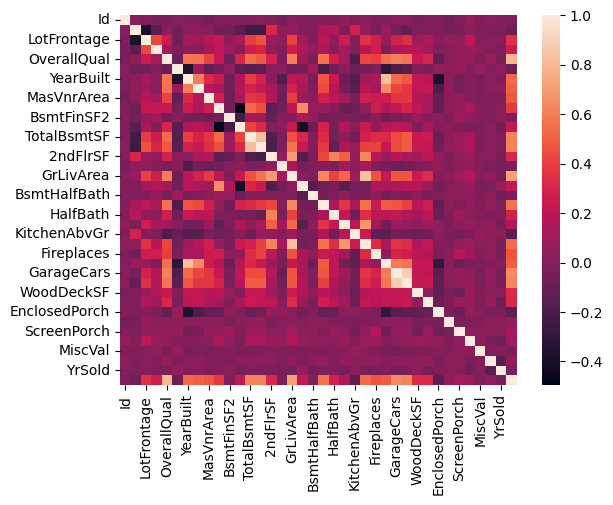

In [12]:
# Our next goal would be to compare the features and see if there are any features that work well with the label (SalePrice)
sns.heatmap(homeprices_train.select_dtypes(include="number").corr())

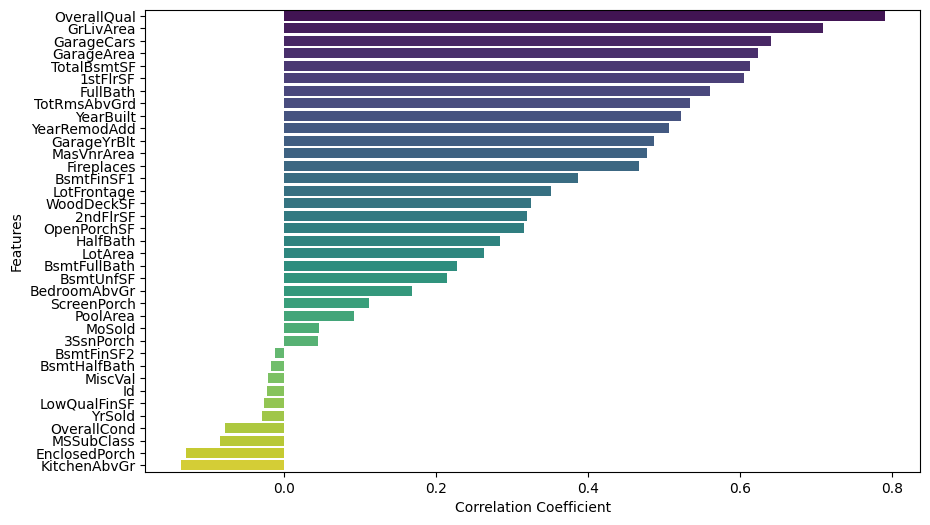

In [13]:
numerical_correlation_list = []

# The above is a bit cluttered and unruly
# Let's see if we can get some more relevant information out of it
corr = homeprices_train.corr(numeric_only=True)
label_corr = corr['SalePrice'].drop('SalePrice').sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=label_corr.values,y=label_corr.index,palette='viridis')
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features")
plt.tight_layout
plt.show()

for num in label_corr.index:
    comp = label_corr[num]
    if comp >= 0.7 or comp <= -0.7:
        numerical_correlation_list.append(num)

In [14]:
# Based on the above numerical correlations we can take a handful of the most
# correlated features and attempt to make a basic model out of them
first_numerical_categories = ["OverallQual","GrLivArea",'GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath']

#### 0.2.2 Categorical features
Will tackle next. The fact I'm getting almost 50% accurate predictions without even touching the categorical features initially looks promising

## 1. Feature engineering & Initial predictions <a class="anchor" id="chapter1"></a>

### 1.1 Feature engineering & Build pipeline <a class="anchor" id="chapter1_1" ></a>
Let's skip feature engineering for now

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder,FunctionTransformer,PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import f_oneway,pearsonr

In [16]:
# Make specific metrics as side-by-side tables for easier comparison purposes
# function that takes a column and provides a more detailed dtype value if it is an object
def get_inferred_type(column):
    if pd.api.types.is_object_dtype(column):
        sample_value = column.dropna().iloc[0]
        return type(sample_value).__name__
    else:
        return column.dtype

# Make a function that returns a comparison dataframe
def comparison_table(df):
    return pd.DataFrame({
        'Data Types':df.apply(get_inferred_type),
        'Missing Values':df.isna().sum(),
        'Unique Values':df.nunique()
    })

In [17]:
# build a function to manually expand the column categories that are giving issues when being put through OneHotEncoding alone
def manual_encode_feature(df,column):
    dummies = pd.get_dummies(df[column],prefix=column)
    df_expanded = pd.concat([df,dummies],axis=1)
    df_expanded = df_expanded.drop(columns=[column])
    df_expanded.columns = df_expanded.columns.str.replace(r'[()\s]','_',regex=True)
    return df_expanded

In [18]:
matches = homeprices_train.applymap(lambda x: 'Membran' in str(x))
matching_indeces = matches[matches].stack().index.tolist()
print("Matching Indecs: ",matching_indeces)

Matching Indecs:  [(271, 'RoofMatl')]


/tmp/ipykernel_17/1347738144.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matches = homeprices_train.applymap(lambda x: 'Membran' in str(x))


In [19]:
matches = homeprices_train.applymap(lambda x: 'Mix' in str(x))
matching_indeces = matches[matches].stack().index.tolist()
print("Matching Indecs: ",matching_indeces)

Matching Indecs:  [(398, 'Electrical')]


/tmp/ipykernel_17/3260912473.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matches = homeprices_train.applymap(lambda x: 'Mix' in str(x))


In [20]:
matches = homeprices_train.applymap(lambda x: 'ImStucc' in str(x))
matching_indeces = matches[matches].stack().index.tolist()
print("Matching Indecs: ",matching_indeces)

/tmp/ipykernel_17/970409909.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matches = homeprices_train.applymap(lambda x: 'ImStucc' in str(x))


Matching Indecs:  [(274, 'Exterior2nd'), (284, 'Exterior2nd'), (358, 'Exterior2nd'), (655, 'Exterior2nd'), (718, 'Exterior2nd'), (779, 'Exterior2nd'), (932, 'Exterior2nd'), (1138, 'Exterior2nd'), (1182, 'Exterior2nd'), (1187, 'Exterior1st'), (1187, 'Exterior2nd')]


In [21]:
column_exploder_list = ['RoofMatl','Electrical']
for column in column_exploder_list:
    homeprices_train = manual_encode_feature(homeprices_train,column)
homeprices_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorc

In [22]:
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    comparison_train = comparison_table(homeprices_train)
    print(comparison_train)

                 Data Types  Missing Values  Unique Values
Id                    int64               0           1460
MSSubClass            int64               0             15
MSZoning                str               0              5
LotFrontage         float64             259            110
LotArea               int64               0           1073
Street                  str               0              2
Alley                   str            1369              2
LotShape                str               0              4
LandContour             str               0              4
Utilities               str               0              2
LotConfig               str               0              5
LandSlope               str               0              3
Neighborhood            str               0             25
Condition1              str               0              9
Condition2              str               0              8
BldgType                str               0             

In [23]:
"""
# Drop the string features with the highest missing values
list_of_columns_to_drop = [
    'PoolQC',
    'Fence',
    'MiscFeature',
    'FireplaceQu',
    'MasVnrType',
    'Alley'
]
homeprices_train = homeprices_train.drop(columns=list_of_columns_to_drop,axis=1)
comparison_train = comparison_train.drop(list_of_columns_to_drop)
"""

"\n# Drop the string features with the highest missing values\nlist_of_columns_to_drop = [\n    'PoolQC',\n    'Fence',\n    'MiscFeature',\n    'FireplaceQu',\n    'MasVnrType',\n    'Alley'\n]\nhomeprices_train = homeprices_train.drop(columns=list_of_columns_to_drop,axis=1)\ncomparison_train = comparison_train.drop(list_of_columns_to_drop)\n"

In [24]:
def manual_expand_features(df):
    comp_table = comparison_table(df)
    for feature in comp_table.index:
        row = comp_table.loc[feature]
        if row['Data Types'] == 'str':
            df = manual_encode_feature(df,feature)
    return df
        
homeprices_train = manual_expand_features(homeprices_train)
comparison_train_v2 = comparison_table(homeprices_train)

with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(comparison_train_v2)

                      Data Types  Missing Values  Unique Values
Id                         int64               0           1460
MSSubClass                 int64               0             15
LotFrontage              float64             259            110
LotArea                    int64               0           1073
OverallQual                int64               0             10
OverallCond                int64               0              9
YearBuilt                  int64               0            112
YearRemodAdd               int64               0             61
MasVnrArea               float64               8            327
BsmtFinSF1                 int64               0            637
BsmtFinSF2                 int64               0            144
BsmtUnfSF                  int64               0            780
TotalBsmtSF                int64               0            721
1stFlrSF                   int64               0            753
2ndFlrSF                   int64        

In [25]:
# Break the features into numerical and categorical
numerical_features = []
categorical_features = []
boolean_features = []

for feature in comparison_train_v2.index:
    if feature != 'SalePrice' and feature != 'Id':
        row = comparison_train_v2.loc[feature]
        if row["Data Types"] == "str":
            categorical_features.append(feature)
        elif row["Data Types"] in ["int64","float64"]:
            numerical_features.append(feature)
        elif row["Data Types"] in ["bool"]:
            boolean_features.append(feature)

len(numerical_features),len(categorical_features),len(boolean_features)

(36, 0, 251)

In [26]:
# Create and return a basic pipeline
# This will have to be updated and expanded as the experimentation progresses
def make_pipeline(features,model_object):
    preprocessor = ColumnTransformer(transformers=[
        ('num',Pipeline([
            ('imputer',SimpleImputer(strategy='mean')),
            ('sclar',StandardScaler())
        ]),features['numerical']),
        #('cat',Pipeline([
        #    ('imputer',SimpleImputer(strategy='most_frequent')),
        #    ('onehot',OneHotEncoder(drop='first',handle_unknown='ignore'))
        #]),features['categorical']),
        ('bool',Pipeline([
            ('to_numeric',FunctionTransformer(lambda x: x.astype(float))),
            ('imputer',SimpleImputer(strategy='most_frequent'))
        ]),features['boolean'])
    ])
    return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('estimator',model_object)
    ])

In [27]:
"""
def one_way_anova(df,features):
    result_list = []
    for category in features:
        groups = [df[df[category] == cat]['SalePrice'] for cat in df[category].unique()]
        f_stat,p_value = f_oneway(*groups)
        if p_value < 0.005:
            result_list.append(category)
            print(f"{category} with a p-value of {p_value:.3f}, was added to the category list; F-statistic: {f_stat:.3f}")
    return result_list

one_way_anova_list = one_way_anova(homeprices_train,categorical_features)
one_way_anova_list
"""

'\ndef one_way_anova(df,features):\n    result_list = []\n    for category in features:\n        groups = [df[df[category] == cat][\'SalePrice\'] for cat in df[category].unique()]\n        f_stat,p_value = f_oneway(*groups)\n        if p_value < 0.005:\n            result_list.append(category)\n            print(f"{category} with a p-value of {p_value:.3f}, was added to the category list; F-statistic: {f_stat:.3f}")\n    return result_list\n\none_way_anova_list = one_way_anova(homeprices_train,categorical_features)\none_way_anova_list\n'

In [28]:
# Compile the lists into another dictionary for pipeline ingestion later
features = {}
features.update({
    'numerical':dist_similar_numerical_features,
    'categorical':[],
    'boolean':boolean_features
})
len(features['numerical']),len(features['categorical']),len(features['boolean'])

(21, 0, 251)

### 1.2 Initial model building & Predictions <a class="anchor" id="chapter1_2" ></a>
* Based on the data we were provided we can use the sklearn map to pick an initial estimator
    * https://scikit-learn.org/1.5/machine_learning_map.html
    * Since we are predicting a quantity, with less than 100k samples, and our initial hypothesis that few features should be important, we can try using `Lasso` and `ElasticNet`

#### 1.2.1 Initial model building

In [29]:
from sklearn.linear_model import Lasso,ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [30]:
# Build out the model dictionary
abacuss = {
    'lasso_page':{
        'model':Lasso()
    },
    'elasticnet_page':{
        'model':ElasticNet()
    },
    'xgbregressor_page':{
        'model':XGBRegressor()
    },
    'gradientregressor_page':{
        'model':GradientBoostingRegressor()
    },
    'tensorflow_random_forest_page':{
        'model':tfdf.keras.RandomForestModel(
            hyperparameter_template="benchmark_rank1",
            task=tfdf.keras.Task.REGRESSION
        )
    }
} # This should house other dictionaries that contain information related to models and their specific metrics (like scoring)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpwzl0tx5k as temporary training directory


In [31]:
# Split the data into feature and label sets
X = homeprices_train.drop(['SalePrice'],axis=1)
y = homeprices_train['SalePrice']

# Split the train and validation sets
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)

#### 1.2.2 Initial scoring and predictions

In [32]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,r2_score,mean_squared_error

In [33]:
# Build a dictionary to hold the scores of the models, and then add a function to add the scores to the dictionary
model_scores = {}

In [34]:
# make a function to score data and update model_scores
def update_model_scores(fit_model,X_train,y_train,X_val,model_tag,model_scores=model_scores,tuned_tag='baseline'):
    preds = pipeline.predict(X_val)
    model_scores.update({
        f'{model_tag} {tuned_tag}':{
            'accuracy':pipeline.score(X_val,y_val),
            'MSE':mean_squared_error(y_val,preds),
            'pipeline':pipeline
        }
    })
    return model_scores

# Build the pipeline iteratively
for page in abacuss:
    pipeline = make_pipeline(features,abacuss[page]['model'])
    if page == 'tensorflow_random_forest_page':
        model = abacuss[page]['model']
        model.fit(tf_dataset_train)
        preds = model.predict(tf_dataset_valid)
        np_data = list(tf_dataset_valid.as_numpy_iterator())
        y_true = np.array([label for _, label in np_data])
        y_true = y_true.reshape(-1)
        model_scores.update({
            f'{page} baseline':{
                'accuracy':accuracy_score(y_true,preds.astype(int)),
                'MSE':mean_squared_error(y_true,preds.astype(int)),
                'pipeline':model
            }            
        })
    else:
        pipeline.fit(X_train,y_train)
        model_scores = update_model_scores(pipeline,X_train,y_train,X_val,page)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.495e+10, tolerance: 7.531e+08
  model = cd_fast.enet_coordinate_descent(


Reading training dataset...
Training dataset read in 0:00:05.865602. Found 1142 examples.
Training model...


[INFO 24-12-13 23:06:37.0376 UTC kernel.cc:1233] Loading model from path /tmp/tmpwzl0tx5k/model/ with prefix 142a3301fb7f4208


Model trained in 0:00:09.429371
Compiling model...


[INFO 24-12-13 23:06:37.4742 UTC decision_forest.cc:734] Model loaded with 300 root(s), 108360 node(s), and 76 input feature(s).
[INFO 24-12-13 23:06:37.4742 UTC abstract_model.cc:1362] Engine "RandomForestGeneric" built
[INFO 24-12-13 23:06:37.4743 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
1/1 [==============================] - 0s 309ms/step


<Axes: >

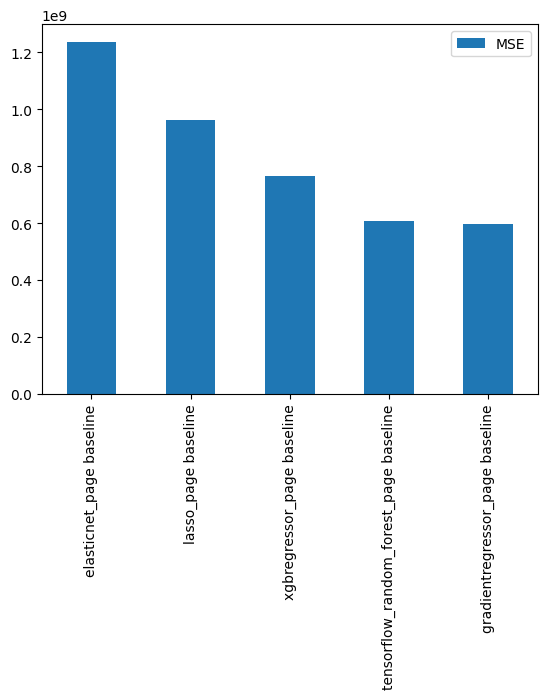

In [35]:
model_compare = pd.DataFrame(model_scores,index=['MSE'])
model_compare.T.sort_values('MSE',ascending=False).plot.bar()

## 2. Hypertuning Parameters & Final model selection <a class='anchor' id='chapter2'></a>
will get back to this later

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter

In [37]:
# Build out a parameter grid to use in the GridSearchCV
lasso_param_grid = {
    'estimator__alpha': [0.0001,0.001,0.01,0.1,1,10,100],
    'estimator__max_iter': [1000,5000,10000]
}

xgboost_param_grid = {
    'estimator__max_depth':[3,5,7],
    'estimator__learning_rate':[0.01,0.05,0.1],
    'estimator__n_estimators':[100,200,500],
    'estimator__subsample':[0.8,1.0],
    'estimator__colsample_bytree':[0.8,1.0],
    'estimator__gamma':[0,1,5],
    'estimator__min_child_weight':[1,5,10]
}

gradientboosting_param_grid = {
    'estimator__learning_rate':[0.01,0.05,0.1],
    'estimator__n_estimators':[100,200,500],
    'estimator__max_depth':[3,5,7],
    'estimator__min_samples_split':[2,5,10],
    'estimator__min_samples_leaf':[1,3,5],
    'estimator__subsample':[0.8,1.0],
    'estimator__max_features':['sqrt','log2',0.8],
    'estimator__loss':['squared_error','huber']
}

In [38]:
# Since the LASSO model has given the best performance\
# we will be adjusting the hyper paramters for it first
"""
lasso_gs = model_scores['lasso_page baseline']['pipeline']
lasso_grid_search = GridSearchCV(
    lasso_gs,
    lasso_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0
)

lasso_grid_search.fit(X_train,y_train)
"""

# Since XGBoost model has given the best performance\
# we will be adjusting the hyperparameteres for it first
"""
xgboost_regressor_model = model_scores['xgbregressor_page baseline']['pipeline']
xgboost_grid_search = GridSearchCV(
    estimator=xgboost_regressor_model,
    param_grid=xgboost_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0,
    n_jobs=-1
)
xgboost_grid_search.fit(X_train,y_train)
"""

# Since GradientBoostingRegressor model has given the best performance\
# we will be adjusting the hyperparameteres for it first
"""
grad_boost_reg_model = model_scores['gradientregressor_page baseline']['pipeline']
grad_boost_reg_grid_search = GridSearchCV(
    estimator=grad_boost_reg_model,
    param_grid=gradientboosting_param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)
grad_boost_reg_grid_search.fit(X_train,y_train)
"""

"\ngrad_boost_reg_model = model_scores['gradientregressor_page baseline']['pipeline']\ngrad_boost_reg_grid_search = GridSearchCV(\n    estimator=grad_boost_reg_model,\n    param_grid=gradientboosting_param_grid,\n    scoring='neg_mean_squared_error',\n    cv=5,\n    verbose=1,\n    n_jobs=-1\n)\ngrad_boost_reg_grid_search.fit(X_train,y_train)\n"

In [39]:
tuned_model_scores = {}

In [40]:
# get the best parameters found through GridSearchCV
#grad_boost_reg_grid_search.best_params_
#grad_boost_reg_grid.best_score_

# results
"""
{'estimator__alpha': 100, 'estimator__max_iter': 1000}
"""

"\n{'estimator__alpha': 100, 'estimator__max_iter': 1000}\n"

In [41]:
# get the best parameters found through GridSearchCV
#lasso_grid_search.best_params_
#lasso_grid_search.best_score_

# results
"""
{'estimator__alpha': 100, 'estimator__max_iter': 1000}
"""

"\n{'estimator__alpha': 100, 'estimator__max_iter': 1000}\n"

In [42]:
"""
# fit the best parameters to the model page
model_scores['lasso_page baseline'].update({
    'best_model':Lasso(
        alpha=100,
        max_iter=1000
    )
})

lasso_tuned = model_scores['lasso_page baseline']['best_model']
lasso_pipe = make_pipeline(features,lasso_tuned)
lasso_pipe.fit(X_train,y_train)
tuned_model_scores = update_model_scores(
    lasso_pipe,
    X_train,
    y_train,
    X_val,
    'lasso',
    tuned_tag='tuned',
    model_scores=tuned_model_scores
)
"""

"\n# fit the best parameters to the model page\nmodel_scores['lasso_page baseline'].update({\n    'best_model':Lasso(\n        alpha=100,\n        max_iter=1000\n    )\n})\n\nlasso_tuned = model_scores['lasso_page baseline']['best_model']\nlasso_pipe = make_pipeline(features,lasso_tuned)\nlasso_pipe.fit(X_train,y_train)\ntuned_model_scores = update_model_scores(\n    lasso_pipe,\n    X_train,\n    y_train,\n    X_val,\n    'lasso',\n    tuned_tag='tuned',\n    model_scores=tuned_model_scores\n)\n"

In [43]:
# get the best patameters found through the GridSearchCV
#xgboost_grid_search.best_params_
#xgboost_grid_search.best_score_

# results
"""
{'estimator__colsample_bytree': 0.8,
 'estimator__gamma': 0,
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': 3,
 'estimator__min_child_weight': 10,
 'estimator__n_estimators': 500,
 'estimator__subsample': 0.8}
"""

"\n{'estimator__colsample_bytree': 0.8,\n 'estimator__gamma': 0,\n 'estimator__learning_rate': 0.1,\n 'estimator__max_depth': 3,\n 'estimator__min_child_weight': 10,\n 'estimator__n_estimators': 500,\n 'estimator__subsample': 0.8}\n"

In [44]:
# fit the best parameters to the model page
"""
model_scores['xgbregressor_page baseline'].update({
    'best_model':XGBRegressor(
        colsample_bytree=0.8,
        gamma=0,
        learning_rate=0.1,
        max_depth=3,
        min_child_weight=10,
        n_estimators=500,
        subsample=0.8
    )
})

tuned_model_scores = update_model_scores(
    make_pipeline(features,model_scores['xgbregressor_page baseline']['best_model']),
    X_train,
    y_train,
    X_val,
    'xgbregressor',
    tuned_tag='tuned',
    model_scores=tuned_model_scores
)
"""

"\nmodel_scores['xgbregressor_page baseline'].update({\n    'best_model':XGBRegressor(\n        colsample_bytree=0.8,\n        gamma=0,\n        learning_rate=0.1,\n        max_depth=3,\n        min_child_weight=10,\n        n_estimators=500,\n        subsample=0.8\n    )\n})\n\ntuned_model_scores = update_model_scores(\n    make_pipeline(features,model_scores['xgbregressor_page baseline']['best_model']),\n    X_train,\n    y_train,\n    X_val,\n    'xgbregressor',\n    tuned_tag='tuned',\n    model_scores=tuned_model_scores\n)\n"

In [45]:
"""
tuned_model_compare = pd.DataFrame(tuned_model_scores,index=['MSE'])
tuned_model_compare.T.sort_values('MSE',ascending=False).plot.bar()
"""

"\ntuned_model_compare = pd.DataFrame(tuned_model_scores,index=['MSE'])\ntuned_model_compare.T.sort_values('MSE',ascending=False).plot.bar()\n"

In [46]:
# make a new pipeline containing the new tuned model parameters
"""
new_pipeline = make_pipeline(features,model_scores['xgbregressor_page baseline']['best_model'])
new_pipeline.fit(X_train,y_train)
"""

"\nnew_pipeline = make_pipeline(features,model_scores['xgbregressor_page baseline']['best_model'])\nnew_pipeline.fit(X_train,y_train)\n"

In [47]:
"""
preds = pipeline.predict(X_val)
model_scores.update({
    f'{page} baseline':{
        'accuracy':pipeline.score(X_val,y_val),
        'MSE':mean_squared_error(y_val,preds),
        'pipeline':pipeline
    }
})
"""

"\npreds = pipeline.predict(X_val)\nmodel_scores.update({\n    f'{page} baseline':{\n        'accuracy':pipeline.score(X_val,y_val),\n        'MSE':mean_squared_error(y_val,preds),\n        'pipeline':pipeline\n    }\n})\n"

## 3. Test data prediction & Submission <a class='Anchor' id='chapter3'></a>

In [48]:
sample_submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [49]:
# Take a look at the data we are given in the make some predictions on the best performing model
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [50]:
# Expand the columns in the same was as was done by the training data
#for column in column_exploder_list:
#    test = manual_encode_feature(test,column)
#test = manual_expand_features(test)
test_dataset_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test,task=tfdf.keras.Task.REGRESSION)

In [51]:
#test = test.reindex(columns=homeprices_train.columns,fill_value=0)

In [52]:
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    print(f"{test.columns}")

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [53]:
# Make predictions and build the submission dictionary
submission = pd.DataFrame({
    'Id':test['Id'],
    'SalePrice':abacuss['tensorflow_random_forest_page']['model'].predict(test_dataset_tf).flatten()
})
submission.head()

2/2 [==============================] - 1s 43ms/step


,Id,SalePrice
0,1461,127985.757812
1,1462,151884.437500
2,1463,177207.968750
3,1464,182942.796875
4,1465,195372.531250


In [54]:
# Save the submission data to csv
submission.to_csv('submission.csv',index=False)